# The AR6 Effective Radiative Forcing Timeseries, 1750-2019

In [1]:
import fair
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.bc_snow import linear
from fair.forcing.landuse import cumulative
from fair.forcing.ghg import etminan, meinshausen
from fair.tools.magicc import scen_open
from scipy.interpolate import interp1d
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as pl
from tqdm.notebook import tqdm
from ar6.utils.h5 import save_dict_to_hdf5
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ods_species, radeff
from ar6.constants import NINETY_TO_ONESIGMA

In [2]:
forcing = {}
scenario = 'ssp245'  # for where decisions are scenario-dependent
samples = 100000
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


In [4]:
emissions_ceds_update.loc[1980:]

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1980,6.375905,876.825931,45.125898,110.570534,24.510851,137.928392,179.712246
1981,6.318720,863.082220,45.492834,108.223143,24.084653,133.823214,175.132196
1982,6.651885,956.814409,46.732739,108.508317,27.421160,131.384954,193.802856
1983,6.350488,850.756862,46.406647,105.401234,23.576389,129.241965,170.695046
1984,6.537589,874.822040,47.402598,108.165518,24.432601,130.508651,175.039932
1985,6.634344,893.343259,48.035251,109.748064,24.901460,130.731998,176.094245
1986,6.769072,900.305387,48.780877,111.364107,25.012513,130.611838,178.498244
1987,6.960361,936.708080,49.796121,115.053049,26.390471,133.133168,186.158734
1988,7.144400,933.095296,50.210322,119.115884,26.273859,133.962927,185.302061


In [5]:
emissions_ceds_update.to_csv('../data_output/emissions_ceds_update_plus_bb.csv')

In [6]:
seed    = 36572 

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(samples,11), loc=np.ones((samples,11)), scale=np.ones((samples, 11)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,7]<1,7] = 0.06/0.1*(scale[scale[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale[scale[:,6]<1,6] = 0.0384/0.0406*(scale[scale[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=samples, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=138294)
#trend_solar[trend_solar>-0.01] = 11/4 * (trend_solar[trend_solar>-0.01]+0.01)-0.01

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

## Solar radiation

ERF = delta TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor. Pre-industrial is defined as the mean TSI for complete solar cycles from 6755 BCE to 1750 CE. See notebook 012.

array([-0.05995826,  0.01023176,  0.07963773])

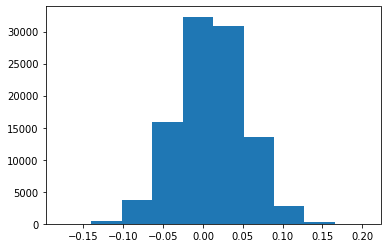

In [7]:
pl.hist(trend_solar)
np.percentile(trend_solar,(5,50,95))

In [8]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
forcing['solar'] = np.zeros((270, samples))
forcing['solar'] = df.solar_erf.loc[1750:2019]

## Volcanic forcing

Use the stratospheric optical depth time series from a combination of Toohey and Sigl (2017; -500 to 1900), CMIP6 (1850-2014), and Glossac (1979-2019). Smoothed overlaps to transition between time series. The zero point is the last-2500 year mean.

ERF = -20 * SAOD based on a combination of CMIP5 models (Larson and Portmann, 2016) and CMIP6 models (my analysis).

The pre-industrial is defined as the SOAD reference from 500 BCE to 1750 CE.

In [9]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
forcing['volcanic'] = df.volcanic_erf.loc[1750:2019]

## Aerosol forcing

ERFari is based on emissions to forcing coefficients from Myhre et al (2013) https://acp.copernicus.org/articles/13/1853/2013/. There is not sufficient evidence from CMIP6 AerChemMIP models or any other sources to update these. The uncertainty ranges from each precursor are expanded slightly compared to Myhre et al., in order to reproduce the overall ERFari uncertainty assessment (assumed that uncertainties in individual components are uncorrelated).

ERFaci is based on fits to CMIP6 models from Smith et al. (2020) https://www.essoar.org/doi/abs/10.1002/essoar.10503977.2

Rescale both to the assessed forcings of -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

In [10]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.70/NINETY_TO_ONESIGMA, size=samples, random_state=31318990)

ERFari = np.zeros((270,samples))
ERFaci = np.zeros((270,samples))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()

for i in tqdm(range(samples), leave=False):
    ts2010 = np.mean(
        ghan(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
    )
    ts1750 = ghan(
        [
            so2[0],
                bc[0]+
                oc[0],
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
    )
    ERFaci[:,i] = (
        ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[97])
nh3_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = nh3_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari = np.zeros((270, samples))
for i in tqdm(range(samples)):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
beta_bc = 0.3/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = -0.09/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = -0.4/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = -0.11/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari_median = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3 
    )

In [13]:
ERFaci_median = np.percentile(ERFaci, 50, axis=1) * (-1.0)/(np.percentile(ERFaci, 50, axis=1)[255:265].mean())

In [14]:
ERFari_median[-15:-5].mean()

-0.29999999999999993

In [15]:
ERFaci_median[-15:-5].mean()

-1.0000000000000002

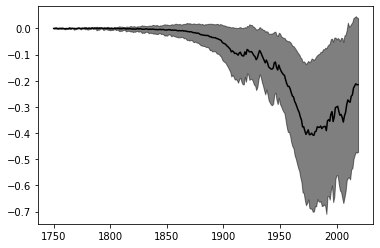

In [16]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari, 5, axis=1), np.percentile(ERFari, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari, 50, axis=1), color='k')

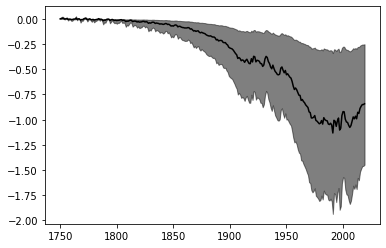

In [17]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFaci, 5, axis=1), np.percentile(ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFaci, 50, axis=1), color='k')

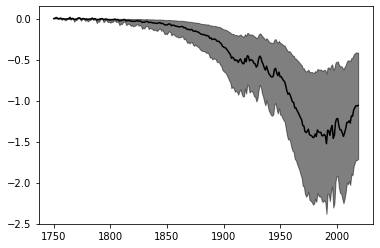

In [18]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari+ERFaci, 5, axis=1), np.percentile(ERFari+ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari+ERFaci, 50, axis=1), color='k')

-1.3


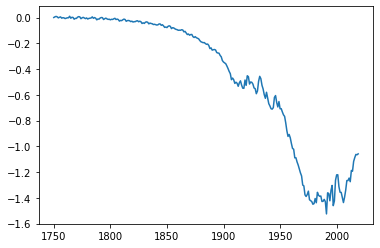

In [19]:
forcing['aerosol-radiation_interactions'] = ERFari_median
forcing['aerosol-cloud_interactions'] = ERFaci_median
forcing['aerosol'] = forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions']
print(forcing['aerosol'][255:265].mean())
pl.plot(forcing['aerosol'])

In [20]:
forcing['aerosol'][-15:]

year
2005   -1.397842
2006   -1.436272
2007   -1.394322
2008   -1.339574
2009   -1.265574
2010   -1.265505
2011   -1.246356
2012   -1.274338
2013   -1.186926
2014   -1.193291
2015   -1.117450
2016   -1.087251
2017   -1.062817
2018   -1.065508
2019   -1.058340
dtype: float64

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

In [21]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/NOx_global_CEDS_emissions_by_sector_2020_09_11.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2019']
avi_nox_hist

,X1750,X1751,X1752,X1753,X1754,X1755,X1756,X1757,X1758,X1759,...,X2010,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1997.776649,2069.475814,2087.063345,2124.952721,2194.826724,2314.759142,2416.613979,2554.457818,2573.144376,2570.985771
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,989.973913,1011.687027,1038.941913,1063.819545,1102.943097,1162.928103,1226.453673,1313.710535,1341.063733,1352.423333


In [22]:
avi_nox_1750_2019 = (avi_nox_hist.sum(axis=0)/1000.).values
contrail_forcing_2018 = 0.0574
forcing['contrails'] = (avi_nox_1750_2019/avi_nox_1750_2019[268] * contrail_forcing_2018)#[:,None] * scale_df['contrails'][None,:]
#pl.plot(np.arange(1750,2020), np.percentile(forcing['contrails'], 95, axis=1))
#pl.plot(np.arange(1750,2020), np.median(forcing['contrails'], axis=1))
#pl.plot(np.arange(1750,2020), np.percentile(forcing['contrails'], 5, axis=1))
forcing['contrails'][-1]

0.05753492821428848

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add -0.05 for irrigation

Based on reading off the graph of the Ghimire paper - could do better maybe but the error will be very small.

In [23]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
ghimire = pd.read_csv('../data_input/Ghimire_et_al_2014_GRL/ghimire_curve_fit.csv')
landuse_co2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values

In [24]:
lusf2019 = -0.15/np.cumsum(landuse_co2)  # include irrigation of -0.05 in Sherwood et al
landuse_erf = np.cumsum(landuse_co2)*lusf2019
f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
lusf2019 = -0.20/(f(2019)-f(1750))
forcing['land_use'] = lusf2019*(f(np.arange(1750,2020))-f(1750))#[:,None] * scale_df['land_use'][None,:]

## BC on snow

Linear with emissions, 2019 ERF = 0.08

In [25]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/BC_global_CEDS_emissions_by_sector_2020_09_11.csv')
bc_hist = df.loc[:,'X1750':'X2019'].sum(axis=0).values/1000.
bc_hist

forcing['bc_on_snow'] = (0.08*(bc_hist[:270]-bc_hist[0])/(bc_hist[269]-bc_hist[0]))#[:,None] * scale_df['bc_on_snow'][None,:]

## Greenhouse gas concentrations

Here, tropospheric and surface adjustments are only implemented for CO2, CH4, N2O, CFC11 and CFC12. There's an argument to uplift ERF by 5% for other GHGs based on land surface warming, but the total forcing will be very small and no single-forcing studies exist.

Radiative efficiencies for F-gases are from Hodnebrog et al. 2020 https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000691

In [26]:
ghg_obs = pd.read_excel('../data_input/observations/LLGHG_history_AR6_v9_updated.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
ghg_obs

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124,YYYY
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.300,729.2000,270.1000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1751,278.372,729.9840,270.1200,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1752,278.444,730.7680,270.1400,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1753,278.516,731.5520,270.1600,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1754,278.588,732.3360,270.1800,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,399.420,1834.0055,328.3025,83.4145,28.042,9.985158,18.0910,17.5655,6.5970,1.096239,...,0.11,0.0,0.412,0.066,0.68,1.05,0.39897,0.083,1.02,NaN
2016,402.850,1842.1665,329.1240,89.4825,28.950,11.972602,20.4815,19.1555,6.6600,1.205802,...,0.11,0.0,0.412,0.067,0.68,1.04,0.42501,0.083,1.02,NaN
2017,405.000,1849.2365,330.0400,95.7485,29.975,14.153317,23.2450,20.8340,6.8175,1.327504,...,0.11,0.0,0.412,0.067,0.68,1.04,0.43989,0.083,1.02,NaN


In [27]:
gases = ghg_obs.columns.to_list()
gases.remove('YYYY')

In [28]:
forcing['co2'] = np.zeros((270,samples))
forcing['ch4'] = np.zeros((270,samples))
forcing['n2o'] = np.zeros((270,samples))
co2base = np.zeros(270)
ch4base = np.zeros(270)
n2obase = np.zeros(270)
c = np.array([ghg_obs['CO2'].values, ghg_obs['CH4'].values, ghg_obs['N2O'].values])
for i, year in enumerate(range(1750,2020)):
    co2base[i], ch4base[i], n2obase[i] = meinshausen(c[:,i], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)

# include rapid adjustments for CO2 and CH4 (FOD numbers):
forcing['co2'] = 1.05 * co2base
forcing['ch4'] = 0.86 * ch4base
forcing['n2o'] = 1.07 * n2obase

In [29]:
trop_adjustment_scale = radeff.copy()
for key in trop_adjustment_scale.keys():
    trop_adjustment_scale[key] = 1
trop_adjustment_scale['CFC-11'] = 1.13
trop_adjustment_scale['CFC-12'] = 1.12

otherghgbase = np.zeros(270)
for gas in gases[3:]:
    forcing[gas] = (ghg_obs.loc[:,gas] - ghg_obs.loc[1750,gas]).values * radeff[gas] * 0.001 * trop_adjustment_scale[gas]
    otherghgbase = otherghgbase + forcing[gas]
forcing['other_wmghg'] = otherghgbase

## Ozone

Taken from Skeie et al and pre-calculated in 024

In [30]:
o3_df = pd.read_csv('../data_output/o3_erf.csv')
forcing['o3'] = o3_df['o3_erf'].values[:270]

## Stratospheric water vapour

In [31]:
forcing['ch4'].shape

(270,)

In [32]:
sfh2ostrat = 0.05 / forcing['ch4'][269]
#forcing['h2o_strat'] = (forcing['ch4'] * sfh2ostrat[None,:]) * scale_df['h2o_stratospheric'][None,:]
forcing['h2o_stratospheric'] = (forcing['ch4'] * sfh2ostrat)
forcing['h2o_stratospheric'].shape

(270,)

Text(0.5, 1.0, 'solar')

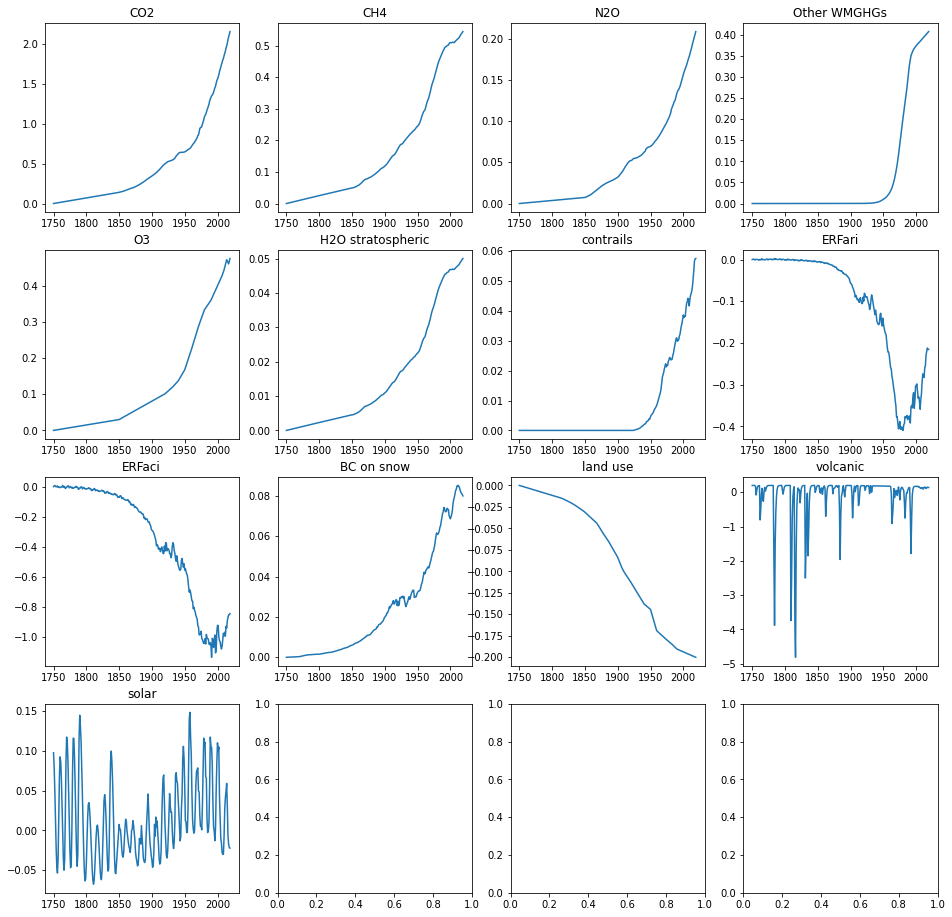

In [33]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].plot(np.arange(1750,2020),forcing['co2'])
ax[0,0].set_title('CO2')
ax[0,1].plot(np.arange(1750,2020),forcing['ch4'])
ax[0,1].set_title('CH4')
ax[0,2].plot(np.arange(1750,2020),forcing['n2o'])
ax[0,2].set_title('N2O')
ax[0,3].plot(np.arange(1750,2020),forcing['other_wmghg'])
ax[0,3].set_title('Other WMGHGs')
ax[1,0].plot(np.arange(1750,2020),forcing['o3'])
ax[1,0].set_title('O3')
ax[1,1].plot(np.arange(1750,2020),forcing['h2o_stratospheric'])
ax[1,1].set_title('H2O stratospheric')
ax[1,2].plot(np.arange(1750,2020),forcing['contrails'])
ax[1,2].set_title('contrails')
ax[1,3].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[1,3].set_title('ERFari')
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,0].set_title('ERFaci')
ax[2,1].plot(np.arange(1750,2020),forcing['bc_on_snow'])
ax[2,1].set_title('BC on snow')
ax[2,2].plot(np.arange(1750,2020),forcing['land_use'])
ax[2,2].set_title('land use')
ax[2,3].plot(np.arange(1750,2020),forcing['volcanic'])
ax[2,3].set_title('volcanic')
ax[3,0].plot(np.arange(1750,2020),forcing['solar'])
ax[3,0].set_title('solar')

In [34]:
forcing['nonco2_wmghg'] = forcing['ch4'] + forcing['n2o'] + forcing['other_wmghg']
forcing['aerosol'] = forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions']
forcing['chapter2_other_anthro'] = ( 
                  forcing['h2o_stratospheric'] + 
                  forcing['contrails'] + 
                  forcing['bc_on_snow'] +
                  forcing['land_use']
)
forcing['total_anthropogenic']=forcing['co2']+forcing['ch4']+forcing['n2o']+\
    forcing['other_wmghg']+\
    forcing['o3']+forcing['h2o_stratospheric']+forcing['contrails']+\
    forcing['aerosol-radiation_interactions']+forcing['aerosol-cloud_interactions']+forcing['bc_on_snow']+forcing['land_use']
forcing['total_natural']=forcing['volcanic']+forcing['solar']
forcing['total']=forcing['total_anthropogenic']+forcing['total_natural']

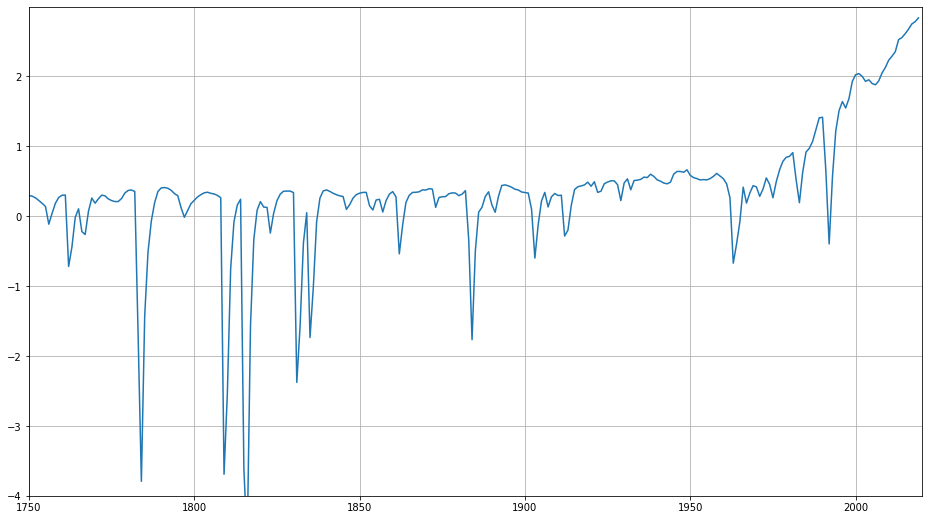

In [35]:
pl.figure(figsize=(16,9))
pl.plot(np.arange(1750,2020), forcing['total'])
pl.yticks(np.arange(-4,3))
pl.xticks(np.arange(1750,2020,50))
pl.ylim(-4,3)
pl.xlim(1750,2020)
pl.grid()

In [36]:
#np.percentile(forcing['total'][-1,:],(5,50,95))
#np.percentile(forcing['total_anthropogenic'][-1,:],(5,50,95))

In [37]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','nonco2_wmghg','aerosol','chapter2_other_anthro',
'total_anthropogenic','total_natural','total']]
df.to_csv('../data_output/AR6_ERF_1750-2019.csv')
df

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199978,0.097590,0.000000,0.000000,0.000000,0.000000,0.297568,0.297568
1751,0.001416,0.000508,0.000074,7.958010e-10,0.000300,0.000047,0.000000,0.000601,0.004674,0.000017,-0.000229,0.199990,0.079244,0.000582,0.005274,-0.000165,0.007408,0.279234,0.286642
1752,0.002832,0.001016,0.000148,1.591602e-09,0.000600,0.000093,0.000000,0.001247,0.007281,0.000035,-0.000458,0.199995,0.049166,0.001164,0.008528,-0.000330,0.012794,0.249161,0.261955
1753,0.004247,0.001524,0.000222,2.387403e-09,0.000900,0.000140,0.000000,0.000537,0.004742,0.000052,-0.000687,0.199996,0.012988,0.001746,0.005278,-0.000495,0.011676,0.212984,0.224661
1754,0.005662,0.002031,0.000296,3.183204e-09,0.001200,0.000187,0.000000,-0.000875,-0.002000,0.000070,-0.000916,0.199996,-0.021427,0.002327,-0.002874,-0.000660,0.005655,0.178570,0.184225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.010013,0.531999,0.196590,4.008144e-01,0.467400,0.048899,0.050999,-0.228510,-0.888940,0.082637,-0.198663,0.109650,0.029197,1.129404,-1.117450,-0.016129,2.473238,0.138847,2.612085
2016,2.058493,0.535044,0.199149,4.025966e-01,0.463533,0.049178,0.053424,-0.219798,-0.867454,0.081655,-0.198998,0.127189,-0.007587,1.136790,-1.087251,-0.014740,2.556825,0.119602,2.676427
2017,2.088686,0.537665,0.202033,4.045765e-01,0.459667,0.049419,0.056725,-0.211978,-0.850840,0.081292,-0.199332,0.150614,-0.017467,1.144275,-1.062817,-0.011896,2.617914,0.133147,2.751061


In [38]:
df.loc[2000:2020]

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
2000,1.560589,0.509299,0.156698,0.374831,0.398767,0.046812,0.038652,-0.301089,-0.920100,0.068669,-0.193651,0.175110,0.110008,1.040828,-1.221189,-0.039517,1.739477,0.285118,2.024595
2001,1.584601,0.508688,0.159142,0.376718,0.402852,0.046756,0.037784,-0.298152,-0.922404,0.069730,-0.193985,0.169849,0.099447,1.044549,-1.220555,-0.039715,1.771732,0.269296,2.041028
2002,1.615021,0.509008,0.161250,0.378431,0.406938,0.046785,0.038350,-0.316748,-0.995662,0.070833,-0.194319,0.176633,0.104735,1.048689,-1.312410,-0.038351,1.719886,0.281368,2.001254
2003,1.653405,0.510596,0.163541,0.379913,0.411024,0.046931,0.038179,-0.332654,-1.023275,0.072814,-0.194654,0.160278,0.043363,1.054050,-1.355929,-0.036729,1.725821,0.203641,1.929461
2004,1.680655,0.510325,0.165675,0.381550,0.415110,0.046906,0.040689,-0.329384,-1.027884,0.076183,-0.194988,0.171193,0.016576,1.057549,-1.357268,-0.031209,1.764837,0.187769,1.952606
2005,1.710913,0.509527,0.167993,0.383259,0.419195,0.046833,0.042421,-0.340762,-1.057081,0.078143,-0.195322,0.143467,-0.009882,1.060779,-1.397842,-0.027925,1.765120,0.133585,1.898705
2006,1.742651,0.509575,0.170727,0.384894,0.423281,0.046837,0.043095,-0.358830,-1.077442,0.079359,-0.195656,0.128362,-0.015888,1.065196,-1.436272,-0.026365,1.768491,0.112474,1.880965
2007,1.768192,0.512215,0.173134,0.386806,0.427367,0.047080,0.044202,-0.335418,-1.058904,0.081129,-0.195990,0.114754,-0.027402,1.072155,-1.394322,-0.023579,1.849812,0.087352,1.937165
2008,1.799057,0.514656,0.176044,0.388804,0.432600,0.047304,0.044006,-0.321557,-1.018017,0.082698,-0.196324,0.131293,-0.029882,1.079504,-1.339574,-0.022315,1.949271,0.101411,2.050683


In [39]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name='year'
df=df[gases[3:]]
df.to_csv('../data_output/AR6_ERF_minorGHGs_1750-2019.csv')
df

,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.013942,0.005359,0.001113,0.004229,0.002951,0.000671,0.000300,0.000036,0.000547,0.000195,...,0.000028,0.000055,0.0,0.000116,0.000016,0.000164,0.000312,0.000060,0.000006,0.000211
2016,0.014956,0.005533,0.001334,0.004788,0.003218,0.000678,0.000329,0.000038,0.000594,0.000212,...,0.000028,0.000055,0.0,0.000116,0.000016,0.000164,0.000309,0.000064,0.000006,0.000211
2017,0.016003,0.005729,0.001577,0.005434,0.003500,0.000694,0.000363,0.000042,0.000646,0.000226,...,0.000028,0.000055,0.0,0.000116,0.000016,0.000164,0.000309,0.000066,0.000006,0.000211


## Uncertainties

In [40]:
forcing_ensemble = {}
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','total_anthropogenic','total_natural','total']]

forcing_ensemble['co2'] = df['co2'].values[:,None] * scale_df['co2'].values[None,:]
forcing_ensemble['ch4'] = df['ch4'].values[:,None] * scale_df['ch4'].values[None,:]
forcing_ensemble['n2o'] = df['n2o'].values[:,None] * scale_df['n2o'].values[None,:]
forcing_ensemble['other_wmghg'] = df['other_wmghg'].values[:,None] * scale_df['other_wmghg'].values[None,:]
forcing_ensemble['o3'] = df['o3'].values[:,None] * scale_df['o3'].values[None,:]
forcing_ensemble['h2o_stratospheric'] = df['h2o_stratospheric'].values[:,None] * scale_df['h2o_stratospheric'].values[None,:]
forcing_ensemble['contrails'] = df['contrails'].values[:,None] * scale_df['contrails'].values[None,:]
forcing_ensemble['aerosol-radiation_interactions'] = ERFari
forcing_ensemble['aerosol-cloud_interactions'] = ERFaci
forcing_ensemble['bc_on_snow'] = df['bc_on_snow'].values[:,None] * scale_df['bc_on_snow'].values[None,:]
forcing_ensemble['land_use'] = df['land_use'].values[:,None] * scale_df['land_use'].values[None,:]
forcing_ensemble['volcanic'] = df['volcanic'].values[:,None] * scale_df['volcanic'].values[None,:]
forcing_ensemble['solar'] = np.linspace(0, trend_solar, 270) + df['solar'].values[:,None] * scale_df['solar'].values[None,:]

Text(0.5, 1.0, 'solar')

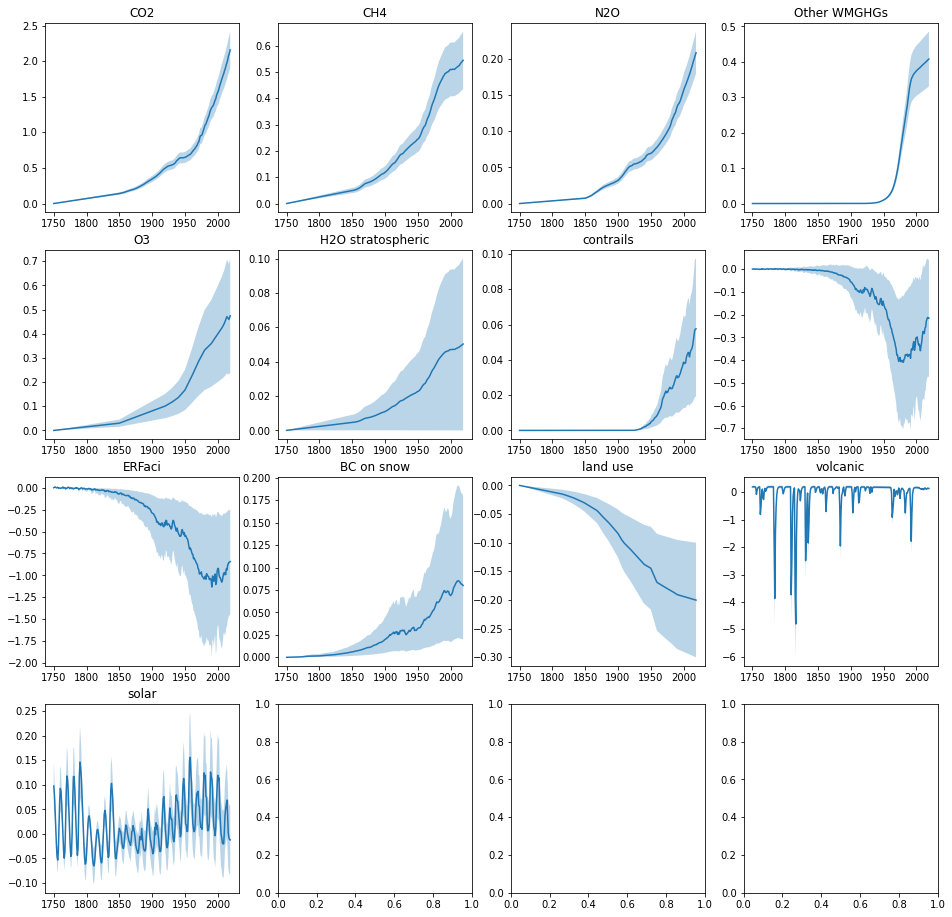

In [41]:
# solar forcing_ensemble will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['co2'],5,axis=1),np.percentile(forcing_ensemble['co2'],95,axis=1), alpha=0.3)
ax[0,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['co2'],axis=1))
ax[0,0].set_title('CO2')
ax[0,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['ch4'],5,axis=1),np.percentile(forcing_ensemble['ch4'],95,axis=1), alpha=0.3)
ax[0,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['ch4'],axis=1))
ax[0,1].set_title('CH4')
ax[0,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['n2o'],5,axis=1),np.percentile(forcing_ensemble['n2o'],95,axis=1), alpha=0.3)
ax[0,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['n2o'],axis=1))
ax[0,2].set_title('N2O')
ax[0,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['other_wmghg'],5,axis=1),np.percentile(forcing_ensemble['other_wmghg'],95,axis=1), alpha=0.3)
ax[0,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['other_wmghg'],axis=1))
ax[0,3].set_title('Other WMGHGs')
ax[1,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['o3'],5,axis=1),np.percentile(forcing_ensemble['o3'],95,axis=1), alpha=0.3)
ax[1,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['o3'],axis=1))
ax[1,0].set_title('O3')
ax[1,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['h2o_stratospheric'],5,axis=1),np.percentile(forcing_ensemble['h2o_stratospheric'],95,axis=1), alpha=0.3)
ax[1,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['h2o_stratospheric'],axis=1))
ax[1,1].set_title('H2O stratospheric')
ax[1,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['contrails'],5,axis=1),np.percentile(forcing_ensemble['contrails'],95,axis=1), alpha=0.3)
ax[1,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['contrails'],axis=1))
ax[1,2].set_title('contrails')
ax[1,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1),np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1), alpha=0.3)
ax[1,3].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[1,3].set_title('ERFari')
ax[2,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1),np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1), alpha=0.3)
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,0].set_title('ERFaci')
ax[2,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['bc_on_snow'],5,axis=1),np.percentile(forcing_ensemble['bc_on_snow'],95,axis=1), alpha=0.3)
ax[2,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['bc_on_snow'],axis=1))
ax[2,1].set_title('BC on snow')
ax[2,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['land_use'],5,axis=1),np.percentile(forcing_ensemble['land_use'],95,axis=1), alpha=0.3)
ax[2,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['land_use'],axis=1))
ax[2,2].set_title('land use')
ax[2,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['volcanic'],5,axis=1),np.percentile(forcing_ensemble['volcanic'],95,axis=1), alpha=0.3)
ax[2,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['volcanic'],axis=1))
ax[2,3].set_title('volcanic')
ax[3,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['solar'],5,axis=1),np.percentile(forcing_ensemble['solar'],95,axis=1), alpha=0.3)
ax[3,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['solar'],axis=1))
ax[3,0].set_title('solar')

In [42]:
print(np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1)[255:265].mean())

forcing_ensemble['total']=(forcing_ensemble['co2'] +
                  forcing_ensemble['ch4'] +
                  forcing_ensemble['n2o'] +
                  forcing_ensemble['other_wmghg'] +
                  forcing_ensemble['o3'] +
                  forcing_ensemble['h2o_stratospheric'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use'] +
                  forcing_ensemble['aerosol-radiation_interactions'] + 
                  forcing_ensemble['aerosol-cloud_interactions'] +
                  forcing_ensemble['solar'] +
                  forcing_ensemble['volcanic'])
forcing_ensemble['aerosol'] = (forcing_ensemble['aerosol-radiation_interactions'] + forcing_ensemble['aerosol-cloud_interactions'])
forcing_ensemble['nonco2_wmghg'] = (forcing_ensemble['ch4'] + forcing_ensemble['n2o'] + forcing_ensemble['other_wmghg'])
forcing_ensemble['chapter2_other_anthro'] = ( 
                  forcing_ensemble['h2o_stratospheric'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use']
)
forcing_ensemble['total_natural'] = forcing_ensemble['solar'] + forcing_ensemble['volcanic']
forcing_ensemble['total_anthropogenic']=(forcing_ensemble['co2'] +
                  forcing_ensemble['ch4'] +
                  forcing_ensemble['n2o'] +
                  forcing_ensemble['other_wmghg'] +
                  forcing_ensemble['o3'] + 
                  forcing_ensemble['h2o_stratospheric'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use'] +
                  forcing_ensemble['aerosol-radiation_interactions'] + 
                  forcing_ensemble['aerosol-cloud_interactions'])

-0.5953941106755677
-0.006333474643782183
-1.7025119340707253
-0.2992355013051683


In [43]:
df = pd.DataFrame(data=np.array([
    np.percentile(forcing_ensemble['co2'],5,axis=1),
    np.percentile(forcing_ensemble['ch4'],5,axis=1),
    np.percentile(forcing_ensemble['n2o'],5,axis=1),
    np.percentile(forcing_ensemble['other_wmghg'],5,axis=1),
    np.percentile(forcing_ensemble['o3'],5,axis=1),
    np.percentile(forcing_ensemble['h2o_stratospheric'],5,axis=1),
    np.percentile(forcing_ensemble['contrails'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1),
    np.percentile(forcing_ensemble['bc_on_snow'],5,axis=1),
    np.percentile(forcing_ensemble['land_use'],5,axis=1),
    np.percentile(forcing_ensemble['volcanic'],5,axis=1),    
    np.percentile(forcing_ensemble['solar'],5,axis=1),
    np.percentile(forcing_ensemble['nonco2_wmghg'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol'],5,axis=1),
    np.percentile(forcing_ensemble['chapter2_other_anthro'],5,axis=1),
    np.percentile(forcing_ensemble['total_anthropogenic'],5,axis=1),
    np.percentile(forcing_ensemble['total_natural'],5,axis=1),
    np.percentile(forcing_ensemble['total'],5,axis=1)
]).T, index=np.arange(1750,2020))
df.index.name = 'year'
df = df.rename(columns={
    0: 'co2',
    1: 'ch4',
    2: 'n2o',
    3: 'other_wmghg',
    4: 'o3',
    5: 'h2o_stratospheric',
    6: 'contrails',
    7: 'aerosol-radiation_interactions',
    8: 'aerosol-cloud_interactions',
    9:'bc_on_snow',
    10:'land_use',
    11:'volcanic',
    12:'solar',
    13:'nonco2_wmghg',
    14:'aerosol',
    15:'chapter2_other_anthro',
    16:'total_anthropogenic',
    17:'total_natural',
    18:'total'
})
df.to_csv('../data_output/AR6_ERF_1750-2019_pc05.csv')
df

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.149525,0.049109,0.000000,0.000000,0.000000,0.000000,0.227459,0.227459
1751,0.001246,0.000406,0.000064,6.445645e-10,0.000151,-4.128610e-08,0.000000,-0.000900,0.000782,0.000004,-0.000344,0.149534,0.039908,0.000480,0.001015,-0.000288,0.003148,0.215081,0.223243
1752,0.002493,0.000812,0.000127,1.289129e-09,0.000301,-8.254724e-08,0.000000,-0.001034,0.001184,0.000009,-0.000688,0.149537,0.024790,0.000959,0.001885,-0.000575,0.006134,0.193285,0.206618
1753,0.003739,0.001218,0.000191,1.933694e-09,0.000452,-1.237835e-07,0.000000,-0.001005,0.000773,0.000013,-0.001032,0.149538,0.006597,0.001438,0.000929,-0.000863,0.007238,0.162318,0.174571
1754,0.004984,0.001623,0.000255,2.578258e-09,0.000602,-1.649948e-07,0.000000,-0.001423,-0.005962,0.000017,-0.001375,0.149538,-0.032069,0.001917,-0.006863,-0.001151,0.001522,0.127418,0.132511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1.769309,0.425028,0.169139,3.246424e-01,0.234588,-4.321258e-05,0.016942,-0.498366,-1.518129,0.020700,-0.298208,0.081986,-0.031343,0.995485,-1.801496,-0.145388,1.696261,0.072810,1.842272
2016,1.811984,0.427461,0.171341,3.260859e-01,0.232647,-4.345991e-05,0.017748,-0.483894,-1.486546,0.020454,-0.298710,0.095100,-0.067020,1.002072,-1.757797,-0.144198,1.789799,0.053112,1.916691
2017,1.838561,0.429555,0.173822,3.276896e-01,0.230706,-4.367282e-05,0.018845,-0.472174,-1.460555,0.020363,-0.299212,0.112615,-0.077672,1.008794,-1.723256,-0.141965,1.859459,0.063439,1.998856


In [44]:
df = pd.DataFrame(data=np.array([
    np.percentile(forcing_ensemble['co2'],95,axis=1),
    np.percentile(forcing_ensemble['ch4'],95,axis=1),
    np.percentile(forcing_ensemble['n2o'],95,axis=1),
    np.percentile(forcing_ensemble['other_wmghg'],95,axis=1),
    np.percentile(forcing_ensemble['o3'],95,axis=1),
    np.percentile(forcing_ensemble['h2o_stratospheric'],95,axis=1),
    np.percentile(forcing_ensemble['contrails'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1),
    np.percentile(forcing_ensemble['bc_on_snow'],95,axis=1),
    np.percentile(forcing_ensemble['land_use'],95,axis=1),
    np.percentile(forcing_ensemble['volcanic'],95,axis=1),    
    np.percentile(forcing_ensemble['solar'],95,axis=1),
    np.percentile(forcing_ensemble['nonco2_wmghg'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol'],95,axis=1),
    np.percentile(forcing_ensemble['chapter2_other_anthro'],95,axis=1),
    np.percentile(forcing_ensemble['total_anthropogenic'],95,axis=1),
    np.percentile(forcing_ensemble['total_natural'],95,axis=1),
    np.percentile(forcing_ensemble['total'],95,axis=1)
]).T, index=np.arange(1750,2020))
df.index.name = 'year'
#df=df[['co2','ch4','n2o','other_wmghg','o3_trop','other_anthro','aerosols','volcanic','solar','total']]
df = df.rename(columns={
    0: 'co2',
    1: 'ch4',
    2: 'n2o',
    3: 'other_wmghg',
    4: 'o3',
    5: 'h2o_stratospheric',
    6: 'contrails',
    7: 'aerosol-radiation_interactions',
    8: 'aerosol-cloud_interactions',
    9:'bc_on_snow',
    10:'land_use',
    11:'volcanic',
    12:'solar',
    13:'nonco2_wmghg',
    14:'aerosol',
    15:'chapter2_other_anthro',
    16:'total_anthropogenic',
    17:'total_natural',
    18:'total'
})
df.to_csv('../data_output/AR6_ERF_1750-2019_pc95.csv')
df

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,nonco2_wmghg,aerosol,chapter2_other_anthro,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250018,0.146720,0.000000,0.000000,0.000000,0.000000,0.367105,0.367105
1751,0.001585,0.000610,0.000084,9.465015e-10,0.000450,0.000094,0.000000,0.002114,0.014754,0.000039,-0.000115,0.250034,0.119186,0.000684,0.015414,-0.000038,0.017550,0.342973,0.352291
1752,0.003170,0.001219,0.000169,1.893003e-09,0.000900,0.000187,0.000000,0.003552,0.023209,0.000078,-0.000229,0.250039,0.073971,0.001368,0.024542,-0.000076,0.028811,0.305051,0.321177
1753,0.004755,0.001829,0.000253,2.839505e-09,0.001349,0.000280,0.000000,0.002093,0.015083,0.000118,-0.000344,0.250040,0.019683,0.002052,0.015674,-0.000114,0.022114,0.263598,0.277070
1754,0.006339,0.002437,0.000338,3.786006e-09,0.001799,0.000374,0.000000,-0.000331,-0.000392,0.000157,-0.000458,0.250041,-0.010594,0.002735,-0.001144,-0.000151,0.007751,0.229966,0.235291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.250246,0.638374,0.224283,4.767165e-01,0.700768,0.097874,0.086371,0.039893,-0.265716,0.185819,-0.099363,0.137087,0.109468,1.262700,-0.439127,0.139893,3.261588,0.224192,3.414943
2016,2.304520,0.642027,0.227202,4.788362e-01,0.694970,0.098434,0.090478,0.042775,-0.259443,0.183612,-0.099530,0.159015,0.071089,1.270811,-0.424560,0.141105,3.333534,0.205365,3.467112
2017,2.338322,0.645173,0.230492,4.811911e-01,0.689173,0.098916,0.096069,0.046710,-0.254243,0.182794,-0.099697,0.188301,0.061807,1.278969,-0.412011,0.144429,3.384266,0.222022,3.533191


## For chapter ES: use 2005-14 forcing for aerosols

In [45]:
forcing['aerosol'].loc[2005:2014].mean()

-1.3

In [46]:
forcing['total_anthropogenic'][2019] - forcing['aerosol'][2019] + forcing['aerosol'].loc[2005:2014].mean()

2.4787388102852113

In [47]:
aerosol_wangle = np.percentile(
    forcing_ensemble['co2'][269]+
    forcing_ensemble['ch4'][269]+
    forcing_ensemble['n2o'][269]+
    forcing_ensemble['other_wmghg'][269]+
    forcing_ensemble['o3'][269]+
    forcing_ensemble['h2o_stratospheric'][269]+
    forcing_ensemble['contrails'][269]+
    forcing_ensemble['bc_on_snow'][269]+
    forcing_ensemble['land_use'][269]+
    forcing_ensemble['aerosol'][255:265,:].mean(axis=0)
,(5,95))
np.savetxt('../data_output/AR6_ERF_1750-PD_pc05pc95_anthro_assessed.csv', aerosol_wangle)
aerosol_wangle

array([1.62754066, 3.34445096])

In [48]:
forcing['total_anthropogenic'][2019]

2.720398543514025

In [49]:
np.percentile(forcing_ensemble['total_anthropogenic'][269], (5,95))

array([1.96288758, 3.48581478])

In [50]:
# all WMGHGs
np.percentile(
    forcing_ensemble['co2'][269] + 
    forcing_ensemble['ch4'][269] + 
    forcing_ensemble['n2o'][269] + 
    forcing_ensemble['other_wmghg'][269]
, (5,95))

array([3.02523959, 3.60744035])

In [51]:
# all GHGs and precursors
np.percentile(
    forcing_ensemble['co2'][269] + 
    forcing_ensemble['ch4'][269] + 
    forcing_ensemble['n2o'][269] + 
    forcing_ensemble['other_wmghg'][269] + 
    forcing_ensemble['o3'][269] +
    forcing_ensemble['h2o_stratospheric'][269]
, (5,95))

array([3.46215867, 4.22040922])

## For Kyle

In [52]:
print('Total 2006-19 minus 1850-1900, 5th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 5) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 5))
print('Total 2006-19 minus 1850-1900, best', forcing['total'][256:270].mean() - forcing['total'][100:151].mean())
print('Total 2006-19 minus 1850-1900, 50th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 50) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 50))
print('Total 2006-19 minus 1850-1900, 95th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 95) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 95))
print()
print('CO2 2006-19 minus 1850-1900, 5th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 5) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 5))
print('CO2 2006-19 minus 1850-1900, best', forcing['co2'][256:270].mean() - forcing['co2'][100:151].mean())
print('CO2 2006-19 minus 1850-1900, 50th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 50) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 50))
print('CO2 2006-19 minus 1850-1900, 95th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 95) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 95))

Total 2006-19 minus 1850-1900, 5th 1.5857042917685649
Total 2006-19 minus 1850-1900, best 2.2017719827751114
Total 2006-19 minus 1850-1900, 50th 2.2199870882198325
Total 2006-19 minus 1850-1900, 95th 2.900969608560227

CO2 2006-19 minus 1850-1900, 5th 1.5089269996376726
CO2 2006-19 minus 1850-1900, best 1.7142074456329872
CO2 2006-19 minus 1850-1900, 50th 1.7149607321645743
CO2 2006-19 minus 1850-1900, 95th 1.9190862370068178


In [53]:
forcing_ensemble['total'].shape

(270, 100000)

## For Matt

In [54]:
forcing_ensemble['year'] = np.arange(1750, 2020)
save_dict_to_hdf5(forcing_ensemble, '../data_output_large/ERF_ensemble.h5')